#### Baseflow recession analysis

Conduct a baseflow recession analysis on all reference gages in blue ridge ecoregion with no missing data from 1984 - 2021.

In [2]:
# load libraries
import geopandas as gpd
import numpy as np
import pandas as pd 
import dataretrieval.nwis as nwis
from datetime import date, timedelta
import pylab
from scipy import stats
from pylr2 import regress2
import pymannkendall as mk

In [3]:
# set home folder
home = "/Volumes/GoogleDrive/My Drive/Chapter2_mechanisms_forest_water_cycling"

# read in the shapefile with location of reference gages
sbr_ref_combo_diss = gpd.read_file(os.path.join(home, "Data", "Catchments", "Reference", "gages_ii","reference_keep.shp"))

In [11]:
def create_recession_df(gage, w, C):

# Function to calculate the time-scaled streamflow recession 
# Inputs
#   Gage: USGS gage ID; String
#   w: Streamflow precision threshold; Numberic
#   c: Scalar to muliply by w. C >= 1; Numeric
# Output
#   Pandas dt of recession events of time scaled log transformed Q and dQ
    
    site = gage

    # Download the streamflow data 
    streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1984-01-01', end = '2009-12-31', parameterCd = '00060') # mean daily ft3/s 
    streamflow_df.reset_index(inplace=True)
    
    # commented out below because we will use estimated values as well for gap-free time series 
    # also only using gages with no missing data, so no need to drop na's 
    #streamflow = streamflow_df[streamflow_df['00060_Mean_cd'] == 'A']
    #streamflow_df.dropna(subset=['00060_Mean'])
    #streamflow = streamflow.reset_index(drop=True)
    streamflow = streamflow_df[["datetime", "00060_Mean"]]
    streamflow.columns = ["Date", "originalQ"] # mean daily ft3/s 

    # Convert from ft3/s to mm/day 
    area_m2 = sbr_ref_combo_diss[sbr_ref_combo_diss['GAGE_ID'] == site].AREA.iloc[0] # m2 
    m2_to_ft2 = 10.7639
    ft_to_mm = 304.8
    s_to_day = 60*60*24
    convert= ((ft_to_mm * s_to_day) / (area_m2 * m2_to_ft2))
    streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)

   
    # calculate dQ and Q 
    streamflow['dQ'] = streamflow['originalQ'].diff()
    # Calculate Q = Qi + Qi-1 / 2 (matches dQ time steps)
    streamflow['Q'] = (streamflow['originalQ'] + (streamflow['originalQ'] + streamflow['dQ'].multiply(-1)))/2
    streamflow = streamflow.reset_index(drop=True)

    # Calculate time-scaled dQ and Q 
    dQ_ts = [np.nan]
    Q_ts = [np.nan]
    for i in range(1, streamflow.shape[0]):
        q_diff = streamflow['originalQ'].iloc[i] - streamflow['originalQ'].iloc[i-1]
        q = np.sum(streamflow['originalQ'].iloc[(i-1):(i +1)])/2
        if abs(q_diff) >= (w*C):
            dQ_ts.append(q_diff)
            Q_ts.append(q)
            continue
    
        steps = 1
        if abs(q_diff) < (w*C):
            for j in range(0, i):
                steps +=1
                q_diff_again = streamflow['originalQ'].iloc[i] - streamflow['originalQ'].iloc[i-steps]
                if abs(q_diff_again) < (w*C):
                    continue
                else: 
                    #dQ_ts.append(q_diff_again/(steps))
                    #Q_ts.append(np.sum(streamflow['originalQ'].iloc[(i-steps):(i+1)])/(steps))
                    date_i = streamflow['Date'].iloc[i]
                    date_old = streamflow['Date'].iloc[(i-steps)]
                    date_diff = date_i - date_old
                    delta = date_diff.days
                    dQ_ts.append(q_diff_again/delta)
                    Q_ts.append(np.sum(streamflow['originalQ'].iloc[(i-steps):(i+1)])/(delta))
                    break
    
    streamflow['dQ_ts'] = dQ_ts
    streamflow['Q_ts'] = Q_ts

    # calculate absolute value of change in dQ
    streamflow['dQdQ'] = streamflow['dQ_ts'].abs().diff()

    # drop non-consecutive dates because that will have an incorrect difference 
    streamflow['day_before'] = pd.concat([pd.Series([np.nan]), streamflow['Date'].iloc[0:(streamflow.shape[0]-1)].add(timedelta(days=1))]).to_list()
    streamflow = streamflow[(streamflow['Date'] == streamflow['day_before'])]
    streamflow = streamflow.drop(['day_before'], axis=1)

    # identify recession events 
    days_to_remove = ( (streamflow['dQ_ts'] >= 0) |   # removes days of non decreasing flow 
                    (streamflow['Q_ts'] <= 0) |   # remove days of 0 streamflow
                    (streamflow['dQdQ'] >= 0)  # remove days where the absolute value of the derivate is not decreasing 
                    )
    decreasing_streamflow = streamflow[-days_to_remove]   

    # Individual events must be at least 5 consecutive days 
    # Remove the first day of each event
    # loop through and increase the counter for every time there is a consevutive date and put that counter in the index for every loop 
    counting_days = []
    consecutive = 0
    for i in range(0, (decreasing_streamflow.shape[0]-1)):
        if i == 0:
            date = decreasing_streamflow['Date'].iloc[i]
            date_next = decreasing_streamflow['Date'].iloc[i+1]
            if (date+timedelta(days=1)) == date_next:
                consecutive += 1
            else: 
                consecutive = 0
            counting_days.append(consecutive)
    
        if i >0:
            date = decreasing_streamflow['Date'].iloc[i]
            date_next = decreasing_streamflow['Date'].iloc[i+1]
            date_prior = decreasing_streamflow['Date'].iloc[i-1]

            if (date+timedelta(days=1)) == date_next:
                consecutive += 1
                counting_days.append(consecutive)  
            elif ( (date+timedelta(days=1) != date_next) & (date-timedelta(days=1) == date_prior)):
                consecutive += 1
                counting_days.append(consecutive)  
                consecutive = 0
            else: 
                consecutive =0
                counting_days.append(consecutive)      

    decreasing_streamflow['consec_days'] = counting_days + [np.nan]   
    decreasing_streamflow = decreasing_streamflow.reset_index(drop=True)

    # find the events that are at least 5 days long 
    idx_gte5 = decreasing_streamflow[decreasing_streamflow['consec_days']>=5].index.tolist()
    idx_1 = decreasing_streamflow[decreasing_streamflow['consec_days']==1].index.tolist()

    K = 0
    for upper_idx in idx_gte5:
        K += 1
        met_condition = [j for j in idx_1 if j<upper_idx ]
        lower_idx = met_condition[len(met_condition)-1]
        if K == 1:
            keep_idx = list(range(lower_idx, upper_idx+1))
        else:
            keep_idx = keep_idx + list(range(lower_idx, upper_idx+1))
    
    final_idx = np.unique(keep_idx)
    recessions = decreasing_streamflow.iloc[final_idx]
    recessions = recessions.reset_index(drop=True)

    # drop the first day of each recession 
    recessions = recessions[recessions['consec_days'] != 1]

    # subset to the months of interest (june - august)
    #recessions = recessions.loc[recessions['Date'].dt.month.isin([6,7,8])]
    recessions = recessions.loc[recessions['Date'].dt.month.isin([6, 7, 8, 9])]

    # label each individual event
    event_number = []
    event_counter = 0
    for i in range(0, recessions.shape[0]):
        if i == 0:
            event_counter = 1
            event_number.append(event_counter)
        else: 
            if recessions['consec_days'].iloc[i] > recessions['consec_days'].iloc[i-1]:
                event_counter = event_counter + 0
                event_number.append(event_counter)
            else:
                event_counter = event_counter + 1
                event_number.append(event_counter)

    recessions['event_number'] = event_number

    # take the log transform of Q and dQ 
    recessions['log_dQ']=np.log10(recessions['dQ_ts'].abs()) # make sure to take the log of the absolute value of dQ
    recessions['log_Q']=np.log10(recessions['Q_ts'])
    
    return recessions


def calculate_coef(df, gage, reg_type, start_year):
# Function to calculate the streamflow recession coefficients
# Inputs 
#   df: output from create_recession_df function above; pandas dt
#   gage: USGS gage id; string
#   reg_type: regression type. Can be "OLS" or "RMA"
#   start_year: year that streamflow starts; numeric
# Outputs
#   dictionary with gage, start year, coefficeints a and b from recession analysis

    if reg_type == "OLS":
        slope, intercept, r_value, p_value, std_err = stats.linregress(df.log_Q, df.log_dQ)
        b_val = slope
        medEvSlope = np.median(b_val)
        df['log_dQ_offset'] = df.log_dQ - (df.log_Q * medEvSlope)
        a_val = np.mean(df.log_dQ_offset)
        return {'Gage':gage, 'Year':start_year, 'A':a_val, 'B':b_val}
    if reg_type == "RMA":
        results = regress2(df.log_Q, df.log_dQ, _method_type_2="reduced major axis")
        b_val = results['slope']
        medEvSlope = np.median(b_val)
        df['log_dQ_offset'] = df.log_dQ - (df.log_Q * medEvSlope)
        a_val = np.mean(df.log_dQ_offset)
        return {'Gage': gage, 'Year':start_year, 'A':a_val, 'B':b_val}



def rolling(df, gage, reg_type, interval):
# Functioni to calculat ethe recession coefficients on a rolling basis 
# Inputs: 
#   df: output from create_recession_df function above; pandas dt
#   gage: USGS gage id; string
#   reg_type: regression type. Can be "OLS" or "RMA"
#   interval: Interval that rolling analysis occurs at; numeric
# Outputs: 
#   dataframe with recession coefficients for each interval

    # make a list of start and end years for each interval 
    start_year = df.Date.iloc[0].year
    end_year = df.Date.iloc[df.shape[0]-1].year
    starts = range(start_year, end_year + 2 - interval)
    ends = [x + (interval-1) for x in starts]

    # loop through each interval 
    coefficients = []
    for i in range(0, len(starts)):
        start = starts[i]
        end = ends[i]
        df_sub = df.loc[df['Date'].dt.year.isin(range(start, end + 1))]
        if df_sub.shape[0] <= 4: 
            continue
        df_sub = df_sub.reset_index(drop=True)
        #coefficients.append(calculate_coef(df_sub, gage, reg_type))
        coefficients.append(calculate_coef(df_sub, gage, reg_type, start))
    
    return pd.DataFrame(coefficients)


In [29]:
def create_recession_df_nots(gage):

# Function to calculate the streamflow recession WITHOUT using time scaling.
# Inputs
#   Gage: USGS gage ID; String
# Output
#   Pandas dt of recession events of time scaled log transformed Q and dQ

    site = gage

    # Download the streamflow data. It is the mean daily discharge ft3/s. 
    # Subset to publication quality observations
    streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1984-01-01', end = '2021-12-31', parameterCd = '00060') # mean daily ft3/s 
    streamflow_df.reset_index(inplace=True)
    #streamflow = streamflow_df[streamflow_df['00060_Mean_cd'] == 'A']
    #streamflow_df.dropna(subset=['00060_Mean'])
    #streamflow = streamflow.reset_index(drop=True)
    streamflow = streamflow_df[["datetime", "00060_Mean"]]
    streamflow.columns = ["Date", "originalQ"] # mean daily ft3/s 

    # Convert from ft3/s to mm/day 
    area_m2 = sbr_ref_combo_diss[sbr_ref_combo_diss['GAGE_ID'] == site].AREA.iloc[0] # m2 
    m2_to_ft2 = 10.7639
    ft_to_mm = 304.8
    s_to_day = 60*60*24
    convert= ((ft_to_mm * s_to_day) / (area_m2 * m2_to_ft2))
    streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)

    # calculate dQ and Q 
    streamflow['dQ'] = streamflow['originalQ'].diff()
    # Calculate Q = Qi + Qi-1 / 2 (matches dQ time steps)
    streamflow['Q'] = (streamflow['originalQ'] + (streamflow['originalQ'] + streamflow['dQ'].multiply(-1)))/2
    streamflow = streamflow.reset_index(drop=True)


    # calculate absolute value of change in dQ
    streamflow['dQdQ'] = streamflow['dQ'].abs().diff()

    # drop non-consecutive dates because that will have an incorrect difference 
    streamflow['day_before'] = pd.concat([pd.Series([np.nan]), streamflow['Date'].iloc[0:(streamflow.shape[0]-1)].add(timedelta(days=1))]).to_list()
    streamflow = streamflow[(streamflow['Date'] == streamflow['day_before'])]
    streamflow = streamflow.drop(['day_before'], axis=1)

    # identify recession events 
    days_to_remove = ( (streamflow['dQ'] >= 0) |   # removes days of non decreasing flow 
                    (streamflow['Q'] <= 0) |   # remove days of 0 streamflow
                    (streamflow['dQdQ'] >= 0)  # remove days where the absolute value of the derivate is not decreasing 
                    )
    decreasing_streamflow = streamflow[-days_to_remove]   

    # Individual events must be at least 5 consecutive days and remove the first day 
    # loop through and increase the counter for every time there is a consevutive date and put that counter in the index for every loop 
    counting_days = []
    consecutive = 0
    for i in range(0, (decreasing_streamflow.shape[0]-1)):
        if i == 0:
            date = decreasing_streamflow['Date'].iloc[i]
            date_next = decreasing_streamflow['Date'].iloc[i+1]
            if (date+timedelta(days=1)) == date_next:
                consecutive += 1
            else: 
                consecutive = 0
            counting_days.append(consecutive)
    
        if i >0:
            date = decreasing_streamflow['Date'].iloc[i]
            date_next = decreasing_streamflow['Date'].iloc[i+1]
            date_prior = decreasing_streamflow['Date'].iloc[i-1]

            if (date+timedelta(days=1)) == date_next:
                consecutive += 1
                counting_days.append(consecutive)  
            elif ( (date+timedelta(days=1) != date_next) & (date-timedelta(days=1) == date_prior)):
                consecutive += 1
                counting_days.append(consecutive)  
                consecutive = 0
            else: 
                consecutive =0
                counting_days.append(consecutive)      

    decreasing_streamflow['consec_days'] = counting_days + [np.nan]   
    decreasing_streamflow = decreasing_streamflow.reset_index(drop=True)

    # find the events that are at least 5 days long 
    idx_gte5 = decreasing_streamflow[decreasing_streamflow['consec_days']>=5].index.tolist()
    idx_1 = decreasing_streamflow[decreasing_streamflow['consec_days']==1].index.tolist()

    K = 0
    for upper_idx in idx_gte5:
        K += 1
        met_condition = [j for j in idx_1 if j<upper_idx ]
        lower_idx = met_condition[len(met_condition)-1]
        if K == 1:
            keep_idx = list(range(lower_idx, upper_idx+1))
        else:
            keep_idx = keep_idx + list(range(lower_idx, upper_idx+1))
    
    final_idx = np.unique(keep_idx)
    recessions = decreasing_streamflow.iloc[final_idx]
    recessions = recessions.reset_index(drop=True)

    # drop the first day of each recession 
    recessions = recessions[recessions['consec_days'] != 1]

    # subset to the months of interest (june - august)
    recessions = recessions.loc[recessions['Date'].dt.month.isin([6,7,8,9, 10])]

    event_number = []
    event_counter = 0
    for i in range(0, recessions.shape[0]):
        if i == 0:
            event_counter = 1
            event_number.append(event_counter)
        else: 
            if recessions['consec_days'].iloc[i] > recessions['consec_days'].iloc[i-1]:
                event_counter = event_counter + 0
                event_number.append(event_counter)
            else:
                event_counter = event_counter + 1
                event_number.append(event_counter)

    recessions['event_number'] = event_number

    # take the log transform of Q and dQ 
    recessions['log_dQ']=np.log10(recessions['dQ'].abs())
    recessions['log_Q']=np.log10(recessions['Q'])
    
    return recessions



In [8]:
# first subset the reference watersheds to those with no missing data 
def check_streamflow(site):
# Function to check that there is no missing data 
    
    # quality control 
    # A = Approved for publication 
    # P = Provisional data subject to revision 
    # e = Value has been estimated 

    streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1900-01-01', parameterCd = '00060')
    if streamflow_df.shape[0] == 0:
        return np.nan
    date_index = streamflow_df.index.to_series().between('1984-01-01', '2021-12-31')
    streamflow_subset = streamflow_df[date_index]
    #streamflow_subset = streamflow_subset[streamflow_subset['00060_Mean_cd'] == 'A']
    streamflow_subset.dropna(subset=['00060_Mean'])
    streamflow = streamflow_subset.reset_index(drop=True)
    # I want to use the estimated values because we can't have gaps 

    sdate = date(1984, 1, 1)
    edate = date(2021, 12, 31)
    delta = edate-sdate
    total_days = delta.days + 1
    
    pct_missing = (streamflow_subset.shape[0]/total_days)*100
    
    return pct_missing


pct_miss= []
for gage_id in sbr_ref_combo_diss['GAGE_ID']:
    pct_miss.append(check_streamflow(gage_id))
sbr_ref_combo_diss['pct_stream'] = pct_miss

sbr_ref_combo_diss_100 = sbr_ref_combo_diss[sbr_ref_combo_diss['pct_stream'] == 100]

In [9]:
# save the shapefile of reference watersheds to use for the analysis 
sbr_ref_combo_diss.to_file(os.path.join(home, "Data", 'Catchments', "Reference", "gages_ii", "reference_keep.shp"))

/Users/katiemcquillan/opt/anaconda3/envs/ch2-python-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [13]:
# create a dataframe with the overall A and B and the slope + pvalue for A and B 
row_list = []
num_years = []
for id in sbr_ref_combo_diss_100.GAGE_ID:
    print(id)
    df = create_recession_df(id, w=0.01, C=3)
    coefs_overall = calculate_coef(df, id, 'RMA', 1984)

    coefs_3r = rolling(df, id, 'RMA', 5)
    coefs_3r['New_Year'] = coefs_3r['Year'] - 1984
    num_years.append(coefs_3r.shape[0])
    # linear regression 
    slope_A, intercept_A, r_value_A, p_value_A, std_err_A = stats.linregress(coefs_3r.New_Year, coefs_3r.A)
    slope_B, intercept_B, r_value_B, p_value_B, std_err_B = stats.linregress(coefs_3r.New_Year, coefs_3r.B)

    # sens slope + mann kendall 
    #mks_A = mk.original_test(coefs_3r['A'])
    #p_value_A = mks_A[2] # p-value 
    #slope_A = mks_A[7] # Theil-Sen estimator/slope 

    #mks_B = mk.original_test(coefs_3r['B'])
    #p_value_B = mks_B[2] # p-value 
    #slope_B = mks_B[7] # Theil-Sen estimator/slope 

    row_list.append({'gage':id, 'A':coefs_overall['A'],'B':coefs_overall['B'], 'int_A':intercept_A,'slope_A':slope_A, 'pvalue_A':p_value_A,'int_B':intercept_B, 'slope_B':slope_B, 'pvalue_B':p_value_B})

recession_results = pd.DataFrame(row_list)
# 678910

#recession_results[(recession_results.pvalue_A <= 0.05) | (recession_results.pvalue_B <= 0.05)]
print(recession_results[(recession_results.pvalue_B <= 0.05)])
print(recession_results[(recession_results.pvalue_A <= 0.05)])
print(num_years)


02053800


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

02056900


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

02069700


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

02070000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

02111500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02118500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02137727


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02143000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02143040


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02149000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02152100


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

02177000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

02178400


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03161000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03164000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

03170000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

03439000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03455500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03456500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03460000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03463300


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03465500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

03471500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

03473000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

03479000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03498500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set

03500000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

03504000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:34: SettingWithCopyWarning: 
A value is trying to be set 

        gage         A         B     int_A   slope_A  pvalue_A     int_B  \
0   02053800 -0.922424  1.894794 -0.959648  0.009049  0.031874  2.577509   
1   02056900 -0.959110  1.512913 -1.010810  0.006726  0.064180  2.278636   
2   02069700 -1.289593  2.089912 -1.585223  0.024749  0.000011  2.582545   
3   02070000 -1.229907  1.873196 -1.444964  0.017997  0.001898  3.528434   
5   02118500 -1.123405  1.680597 -1.300219  0.016896  0.000573  2.760927   
6   02137727 -1.242049  1.733746 -1.495310  0.014643  0.002867  2.487280   
9   02149000 -1.277837  1.991802 -1.466934  0.008537  0.180333  2.934011   
10  02152100 -1.162399  1.799285 -1.323631  0.008392  0.068443  3.105179   
12  02178400 -1.571800  2.238606 -1.595143 -0.000128  0.960894  2.071591   
15  03170000 -1.137224  1.985173 -1.292841  0.016161  0.000280  2.665614   
17  03455500 -1.356277  1.896497 -1.730019  0.022733  0.005753  3.180963   
19  03460000 -1.381231  2.301398 -1.388543 -0.000176  0.950967  3.125015   
20  03463300

/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_89756/1281395363.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decreasing_streamflow['consec_days'] = counting_days + [np.nan]


In [23]:
# save results of the streamflow recession 
recession_results.to_csv(os.path.join(home, "Data", "Streamflow", "baseflow_recession.csv"), index=False)

/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_9639/1812196582.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_9639/1812196582.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_9639/1812196582.py:112: SettingWithCopyWarning: 
A value is trying to be set on

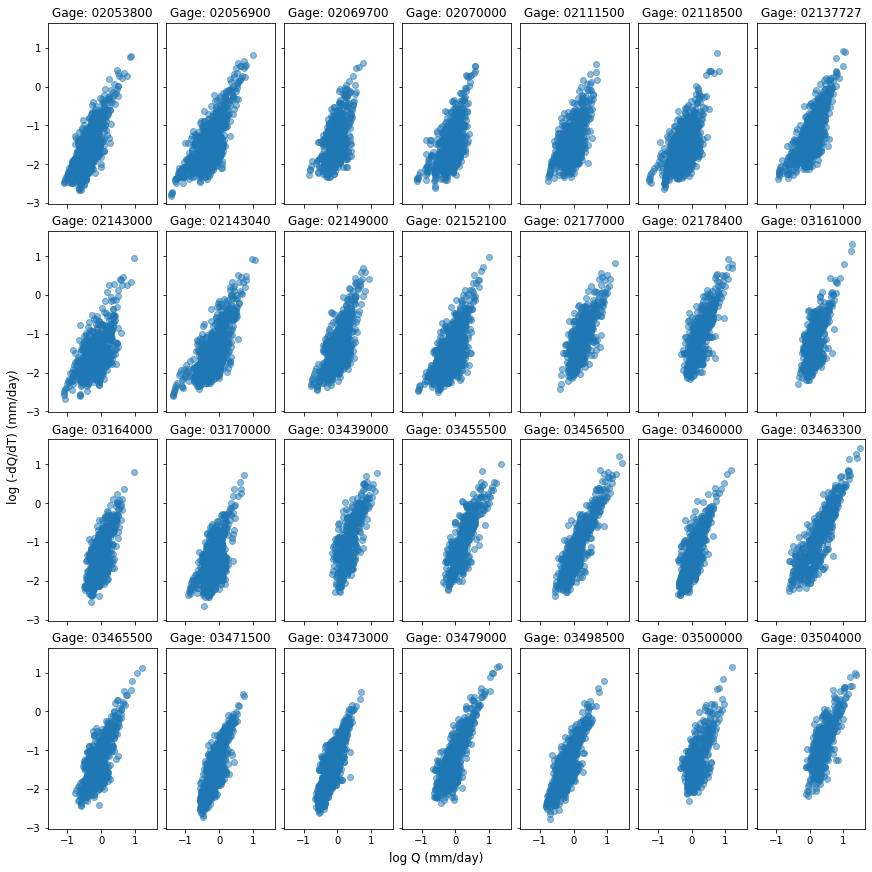

In [38]:
# plot the results of the streamflow recession as dq v q 
#fig, axes = pylab.subplots(nrows=7, ncols=4, figsize=(21,9), sharex=True, sharey=True)
fig, axes = pylab.subplots(nrows=4, ncols=7, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True,)

for i, ax in enumerate(axes.flatten()):
    site = recession_results.gage.iloc[i]
    recessions = create_recession_df(site, w=0.01, C=3)
    ax.plot(recessions['log_Q'], recessions['log_dQ'],'o', alpha=0.5)
    #ax.set_xlabel("log Q (mm/day)")
    #ax.set_ylabel('log (-dQ/dT) (mm/day)')
    ax.set_title('Gage: ' + site)

fig.supxlabel('log Q (mm/day)')
fig.supylabel('log (-dQ/dT) (mm/day)')
#pylab.xlabel("log Q (mm/day)")
#pylab.ylabel("log (-dQ/dT) (mm/day)")

pylab.show()

In [45]:
# Also calculate the recession slope analysis using the regular recession slope calculation (no time-scaled dt)
row_list = []
for id in sbr_ref_combo_diss_100.GAGE_ID:
    print(id)
    df = create_recession_df_nots(id)
    coefs_overall = calculate_coef(df, id, 'RMA')

    coefs_3r = rolling(df, id, 'RMA', 3)
    # linear regression 
    #slope_A, intercept_A, r_value_A, p_value_A, std_err_A = stats.linregress(coefs_3r.Year, coefs_3r.A)
    #slope_B, intercept_B, r_value_B, p_value_B, std_err_B = stats.linregress(coefs_3r.Year, coefs_3r.B)

    # sens slope + mann kendall 
    mks_A = mk.original_test(coefs_3r['A'])
    p_value_A = mks_A[2] # p-value 
    slope_A = mks_A[7] # Theil-Sen estimator/slope 

    mks_B = mk.original_test(coefs_3r['B'])
    p_value_B = mks_B[2] # p-value 
    slope_B = mks_B[7] # Theil-Sen estimator/slope 

    row_list.append({'gage':id, 'A':coefs_overall['A'],'B':coefs_overall['B'], 'slope_A':slope_A, 'pvalue_A':p_value_A, 'slope_B':slope_B, 'pvalue_B':p_value_B})

recession_results_nots = pd.DataFrame(row_list)

02053800


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

02056900


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

02069700


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

02070000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

02111500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02118500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02137727


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02143000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02143040


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02149000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02152100


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

02177000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

02178400


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03161000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03164000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

03170000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

03439000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03455500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03456500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03460000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03463300


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03465500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

03471500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

03473000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

03479000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03498500


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

03500000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

03504000


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:27: SettingWithCopyWarning: 
A value is trying to be set 

/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_53060/3225424783.py:76: SettingWithCopyWarning: 
A value is trying to be set 

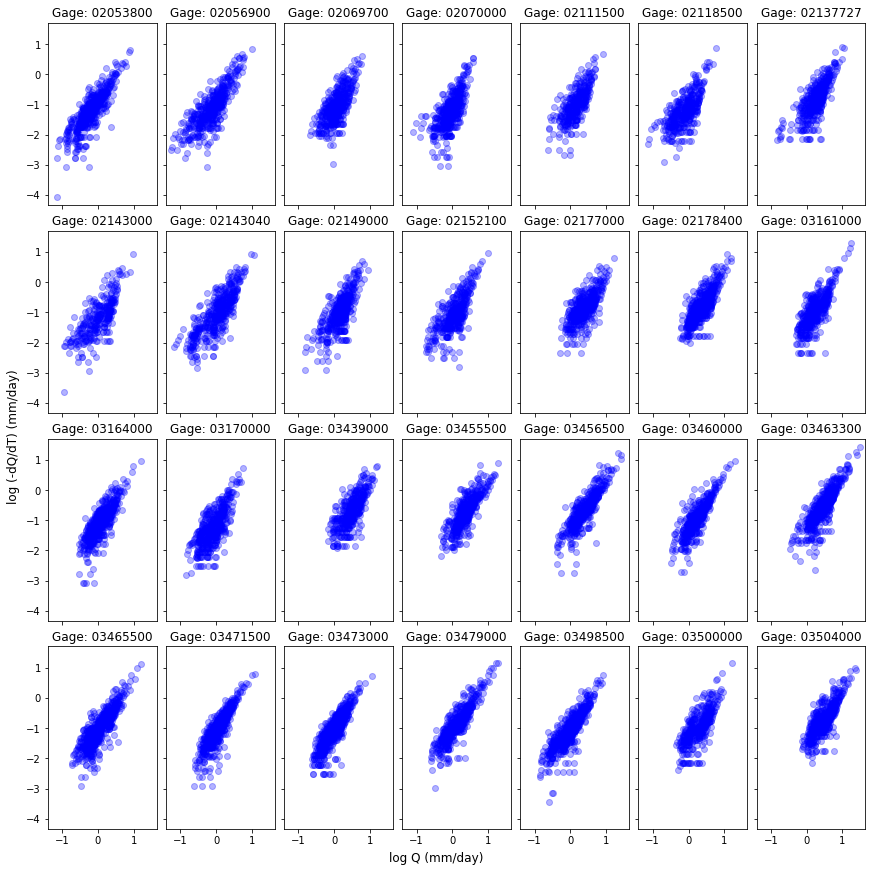

In [51]:
# it's clear from looking at the plots that when you don't use time scaled dt the smaller values are discretized

fig, axes = pylab.subplots(nrows=4, ncols=7, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True,)

for i, ax in enumerate(axes.flatten()):
    site = recession_results_nots.gage.iloc[i]
    recessions = create_recession_df_nots(site)
    ax.plot(recessions['log_Q'], recessions['log_dQ'],'o', alpha=0.3, color = 'blue')
    ax.set_title('Gage: ' + site)

fig.supxlabel('log Q (mm/day)')
fig.supylabel('log (-dQ/dT) (mm/day)')
#pylab.xlabel("log Q (mm/day)")
#pylab.ylabel("log (-dQ/dT) (mm/day)")

pylab.show()